In [300]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from utils import angle_mod

In [ ]:
import sys
sys.path.append('../3DGS_PoseRender/')

In [301]:
import os
from PIL import Image
from camera import Camera
from gaussian_model import GaussianModel
from render import Renderer

from utils import rotation_matrix_y

In [302]:
import torchvision.transforms as transforms

In [303]:
def dynamics(state, control):
    """
    simplified kinematic blimp dynamics

    The state of the blimp is q = (x, y,z, w), where (x, y, z) is the position,
    theta is the yaw angle. The control input is (dx,dy,dz,dw)
    The dynamics are given by
      x' = dx
      y' = dy
      z' = dz
      w' = dw
    """
    state = np.array(state)
    x, y, z, theta = state.T if len(state.shape) > 1 else state
    theta = angle_mod(theta)
    vx, vy, w ,h = control.T if len(control.shape) > 1 else control
    dx = vx * np.cos(theta) + vy * np.sin(theta)
    dy = vx * np.sin(theta) - vy * np.cos(theta)
    dz = h
    dtheta = w
    # state = np.expand_dims(state) if len(state.shape) == 1 else state
    next_state = np.array([x + dx, y + dy, z + dz, angle_mod(theta + dtheta)]).T
    return next_state

In [304]:
# Initialize lists to store trajectories, controls and probability_map
all_trajs = []
all_controls = []
all_prob_maps = []

# Loop through the files in the directory
for filename in sorted(os.listdir('./pie_temp/task_5/'), key=lambda x: int(x.split('_')[-1].split('.')[0])):
    if filename.startswith('rollout_traj_') and filename.endswith('.npy'):
        traj = np.load(os.path.join('./pie_temp/task_5/', filename))
        all_trajs.append(traj)
    elif filename.startswith('control_') and filename.endswith('.npy'):
        control = np.load(os.path.join('./pie_temp/task_5/', filename))
        all_controls.append(control)
    elif filename.startswith('prob_grid_') and filename.endswith('.npy'):
        prob_map = np.load(os.path.join('./pie_temp/task_5/', filename))
        all_prob_maps.append(prob_map)

In [305]:
states = [np.array([2, 2, 0.5, -np.pi/2])]
# states = [np.array([2, 2, 0.3, np.pi])]
for index,control in enumerate(all_controls):
    next_state = dynamics(states[index], control)
    states.append(next_state)

# Animation

In [317]:
def animate_simulation(states, pred_trajs, opt_trajs=None):
    def update(frame, states):
        # 清除当前的轴
        plt.gca().cla()

        # 设置轴的范围
        # plt.xlim([-3, 4])
        # plt.ylim([-3, 4])
        plt.xlim([-4, 4])
        plt.ylim([-4, 4])

        # 设置纵横比相等，使每个单元格为正方形
        plt.gca().set_aspect('equal', adjustable='box')

        # 绘制MPPI轨迹
        for traj in pred_trajs[frame]:
            x_pos = traj[:,0]
            y_pos = traj[:,1]
            plt.plot(x_pos, y_pos, color="black", alpha=0.1)
        

        # 获取当前帧的状态
        x, y, _, theta = states[frame]
        theta = angle_mod(theta)
        dx = 0.1 * np.cos(theta)
        dy = 0.1 * np.sin(theta)


        # 绘制起点和终点
        # 绘制起点和终点
        plt.scatter(2, 2, s=50, color="green", alpha=0.5, label="init. position")
        # plt.scatter(0.8, 2.3, s=50, color="purple", alpha=0.5, label="target position")
        # plt.scatter(1, 0.2, s=50, color="purple", alpha=0.5, label="target position")
        # plt.scatter(0, -1, s=50, color="purple", alpha=0.5, label="target position")
        # plt.scatter(-2.6, -1.1, s=50, color="purple", alpha=0.5, label="target position")
        plt.scatter(1.5, 2.8, s=50, color="purple", alpha=0.5, label="target position")
        # plt.scatter(-0.6, 2.8, s=50, color="purple", alpha=0.5, label="target position")
        # plt.scatter(0.55, 0.2, s=50, color="purple", alpha=0.5, label="target position")

        # 绘制起点到state[0]的一条轨迹

        # 绘制到当前帧的轨迹
        plt.plot([state[0] for state in states[:frame+1]], [state[1] for state in states[:frame+1]], '-o', markersize=4, alpha=0.5)

        # 绘制当前帧的方向
        plt.arrow(x, y, dx, dy, head_width=0.2, head_length=0.2, fc='red', ec='red')

        

        # plot a rectangle to represent the boundary
        plt.gca().add_patch(plt.Rectangle((-3.2, -3.2), 6.4, 6.4, fill=False, color='black', linestyle='--', linewidth=2))
        # plt.gca().add_patch(plt.Rectangle((-2.2, -2.2), 5.4, 5.4, fill=False, color='black', linestyle='--', linewidth=2))

        # plot a pure black circle to represent the objects
        # plt.gca().add_patch(plt.Circle((1.36, 1.31), np.sqrt(0.04), color='black', fill=True, linestyle='-', linewidth=2))
        # plt.gca().add_patch(plt.Circle((1.3, -0.8), np.sqrt(0.04), color='black', fill=True, linestyle='-', linewidth=2))
        # plt.gca().add_patch(plt.Circle((0, -0), np.sqrt(0.04), color='black', fill=True, linestyle='--', linewidth=2))

        # 设置图形标题
        # plt.title('Result with image similarity, cost and probability')
        # 设置x轴标签
        # plt.xlabel('X Position (m)')
        # # 设置y轴标签
        # plt.ylabel('Y Position (m)')
        # 显示网格
        plt.grid(True)
        # 显示图例
        plt.legend(loc="upper left")

    # 创建一个6x6的图形
    fig = plt.figure(figsize=(6, 6))
    # 创建动画
    anim = FuncAnimation(fig, update, frames=len(states)-1, fargs=(states,), interval=200, blit=False)
    # 保存动画为GIF文件
    anim.save('task_5.gif', writer='imagemagick')

In [307]:
print(all_controls[-2])

[ 0.         -0.03827035  0.         -0.0215909 ]


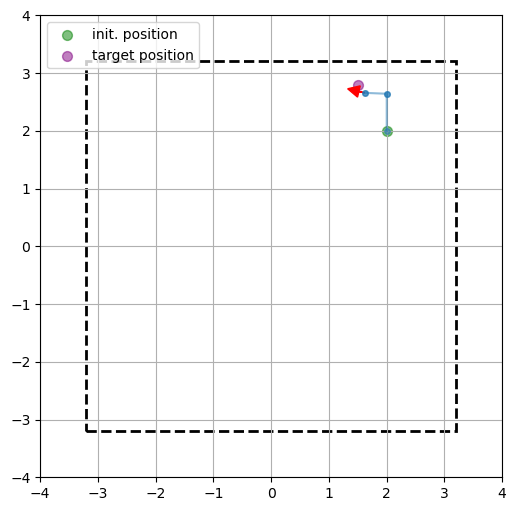

In [318]:
animate_simulation(states[:6],all_trajs[:6])

In [16]:
def plot_probability_grid(probability):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set the plot limits
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    
    # Draw the black dashed square
    # ax.add_patch(plt.Rectangle((-2.2, -2.2), 5.4, 5.4, fill=False, color='black', linestyle='--', linewidth=2))
    ax.add_patch(plt.Rectangle((-3.2, -3.2), 6.4, 6.4, fill=False, color='black', linestyle='--', linewidth=2))
    
    # # Create a meshgrid for the heatmap
    # x = np.arange(-2, 3, 1)
    # y = np.arange(-2, 3, 1)
    # X, Y = np.meshgrid(x, y)
    
    # # Plot the heatmap
    # im = ax.pcolormesh(X, Y, probability, cmap='viridis', alpha=0.7)
    
    # # Add colorbar
    # plt.colorbar(im)
    # 绘制半透明的栅格热图
    # cax = ax.imshow(probability, extent=(-2, 3, -2, 3), cmap='viridis', alpha=0.5)
    cax = ax.imshow(probability, extent=(-3, 3, -3, 3), cmap='viridis', alpha=0.5)
    # 添加颜色条
    fig.colorbar(cax, ax=ax)
    # Loop over data dimensions and create text annotations.
    for i in range(probability.shape[0]):
        for j in range(probability.shape[1]):
            # ax.text(-1.5+j, 2.5-i, f"{probability[i,j]:.4f}", ha="center", va="center", color="black")
            ax.text(-2.5+j, 2.5-i, f"{probability[i,j]:.4f}", ha="center", va="center", color="black")
            
    
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('w Probability Grid')
    
    # Show the grid
    ax.grid(True, which='both', linestyle=':', color='gray', alpha=0.5)
    # 设置轴的比例相等
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.show()

In [620]:
# print(states)
# #save states to npy file
# np.save('states.npy', states)

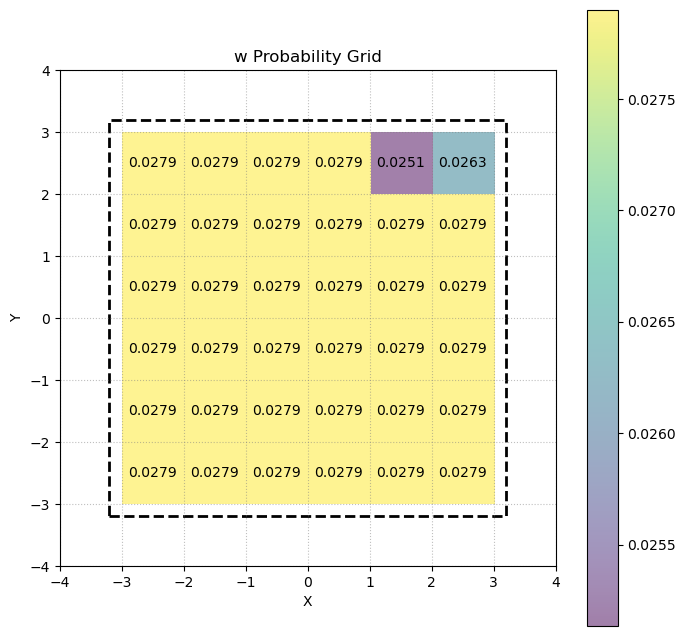

In [320]:
plot_probability_grid(all_prob_maps[5])

In [13]:
def save_probability_grid(probability,name):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set the plot limits
    ax.set_xlim(-3, 4)
    ax.set_ylim(-3, 4)
    
    # Draw the black dashed square
    ax.add_patch(plt.Rectangle((-2.2, -2.2), 5.4, 5.4, fill=False, color='black', linestyle='--', linewidth=2))
    
    # # Create a meshgrid for the heatmap
    # x = np.arange(-2, 3, 1)
    # y = np.arange(-2, 3, 1)
    # X, Y = np.meshgrid(x, y)
    
    # # Plot the heatmap
    # im = ax.pcolormesh(X, Y, probability, cmap='viridis', alpha=0.7)
    
    # # Add colorbar
    # plt.colorbar(im)
    # 绘制半透明的栅格热图
    cax = ax.imshow(probability, extent=(-2, 3, -2, 3), cmap='viridis', alpha=0.5)
    # 添加颜色条
    fig.colorbar(cax, ax=ax)
    # Loop over data dimensions and create text annotations.
    for i in range(probability.shape[0]):
        for j in range(probability.shape[1]):
            ax.text(-1.5+j, 2.5-i, f"{probability[i,j]:.4f}", ha="center", va="center", color="black")
            
    
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('w Probability Grid')
    
    # Show the grid
    ax.grid(True, which='both', linestyle=':', color='gray', alpha=0.5)
    # 设置轴的比例相等
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.savefig(name)

In [ ]:
import os

# Define the directory where the images will be saved
save_dir = "./rendered_path/target2_31/belief"

# Ensure the directory exists
os.makedirs(save_dir, exist_ok=True)

# Loop over all_prob_maps and save each as a PNG image
for i, prob_map in enumerate(all_prob_maps):
    # Construct the file name using the index
    file_name = f"{i:02d}.png"
    # Construct the full path
    full_path = os.path.join(save_dir, file_name)
    # Save the probability grid as an image
    save_probability_grid(prob_map, full_path)


In [135]:
from camera import Camera
from gaussian_model import GaussianModel
from render import Renderer

from utils import rotation_matrix_y

In [236]:
model_path = "..scence/03/larger.ply" # Path to the ply file model
camera = Camera()
camera_info = {'width': 1920,
                'height': 1440,
                'position': [0, -0.5, 0],
                'rotation': [[1,0,0],[0,1,0],[0,0,1]],
                'fy': 1371.7027360999618,
                'fx': 1371.7027360999618}
camera.load(camera_info)
gaussian_model = GaussianModel().load(model_path)
renderer = Renderer(gaussian_model, camera, logging=False)

d:\Conda\envs\anyloc\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [309]:
states = np.array(states)

In [238]:
# np.save('states.npy', states)

In [239]:
def transform_state(state):
    # new_state has same shape with state
    new_state = state.copy()
    # rotate the state 180 degree along y-axis
    new_state[:,:3] = -state[:,:3]
    # switch new_state[:,:,1] and new_state[:,:,2]
    new_state[:,1], new_state[:,2] = new_state[:,2].copy(), new_state[:,1].copy()
    new_state[:,3] = -(state[:,3]+np.pi/2)
    return new_state

In [310]:
render_states = transform_state(states)

In [311]:
for index,state in enumerate(render_states):
    camera.update(state[:3],rotation_matrix_y(state[3]))
    im = renderer.render()
    # use plt to save
    plt.imsave(f'./rendered_path/task_5/{index:04d}_{state[0]:.2f}_{state[1]:.2f}_{state[2]:.2f}_{state[3]:.2f}.png', im.detach().cpu().numpy().transpose(1, 2, 0))